# <center style='color:tan'> Convolutional Variational AutoEncoder (CVAE) - Example using MNIST dataset </center>

## 1. Import the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the device

In [2]:
print('PyTorch version:', torch.__version__, '\n')
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

PyTorch version: 2.1.2 

GPU name: NVIDIA GeForce RTX 3060 Laptop GPU 

Device is: cuda 

Total number of GPUs: 1


## 3. Load USPS dataset

In [3]:
t = transforms.Compose([
    # transforms.Resize(28),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="dataset/",
                         train=True,
                         transform=t,
                         download=True)

test_dataset = datasets.MNIST(root="dataset/",
                              train=False,
                              transform=t,
                              download=True,)
# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=batch_size,
#                           shuffle=True)

In [4]:
# check the length of training and test datasets

print('Length of the training dataset:', len(train_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 60000
Length of the test dataset: 10000


In [5]:
# check the shape of training and test datasets
print('Shape of the training dataset:', train_dataset.data.shape)
print('Shape of the test dataset:', test_dataset.data.shape)

Shape of the training dataset: torch.Size([60000, 28, 28])
Shape of the test dataset: torch.Size([10000, 28, 28])


Shape: (total images, height, width)

#### The `spatial dimension` of the `grayscale images` in the `USPS dataset` is `16x16` pixels

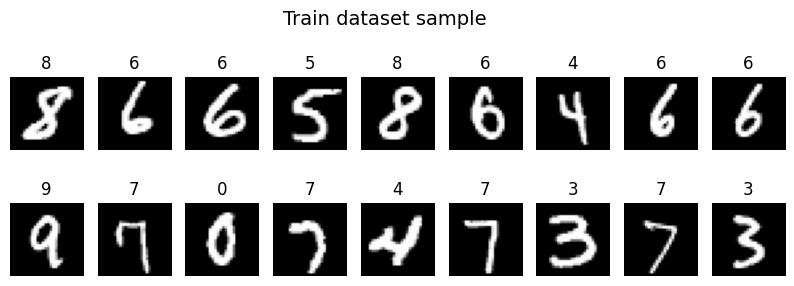

In [6]:
# show 18 randomly selected samples from the training dataset
fig, axis = plt.subplots(nrows=2, ncols=9, figsize=(10, 3))

for ax, _ in zip(axis.ravel(), range(18)):
    inx = np.random.randint(len(train_dataset))
    ax.imshow(train_dataset.data[inx], cmap='Greys_r')
    ax.set_title(train_dataset.targets[inx].item(), fontsize=12)
    ax.axis(False);
plt.suptitle("Train dataset sample", y=1.05, fontsize=14)
plt.show()

## 4. Define dataloaders

In [7]:
training_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [8]:
# check the length of training and test dataloaders

print('Length of the training dataloader:', len(training_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

Length of the training dataloader: 937
Length of the test dataloader: 156


Since, neither 7291 nor 2007 is divisible by 32; the last batch will not have 32 images in it and hence I dropped it. 227 and 62 are showing the number of batches in training and test dataloaders, respectively.

#### Dataloader converts a dataset into an iterable

## 5. Define the network architecture

In [9]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Conv_VAE(nn.Module):
    def __init__(self):
        super(Conv_VAE, self).__init__()
        
        self.encoder = nn.Sequential()
        self.encoder.add_module('conv1',  nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2))
        self.encoder.add_module('bnorm1', nn.BatchNorm2d(num_features=8))
        self.encoder.add_module('relu1',  nn.ReLU(inplace=True))
        self.encoder.add_module('conv2',  nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2))
        self.encoder.add_module('bnorm2', nn.BatchNorm2d(num_features=16))
        self.encoder.add_module('relu2',  nn.ReLU(inplace=True))
        self.encoder.add_module('conv3',  nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2))
        self.encoder.add_module('bnorm3', nn.BatchNorm2d(num_features=32))
        self.encoder.add_module('relu3',  nn.ReLU(inplace=True))
        
        self._mu = nn.Linear(in_features=128, out_features=2)
        self._logvar = nn.Linear(in_features=128, out_features=2)
        self._lat2hid = nn.Linear(in_features=2, out_features=128)

        self.decoder = nn.Sequential()
        self.decoder.add_module('lat2hid', nn.Linear(in_features=2, out_features=128))
        self.decoder.add_module('relu4', nn.ReLU(inplace=True))
        self.decoder.add_module('reshape', Reshape(-1, 32, 2, 2))
        self.decoder.add_module('tconv3', nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=1,
                                            output_padding=1))
        self.decoder.add_module('bnorm4', nn.BatchNorm2d(num_features=16))
        self.decoder.add_module('relu5', nn.ReLU(inplace=True))
        self.decoder.add_module('tconv2', nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=2, padding=1,
                                            output_padding=1))
        self.decoder.add_module('bnorm5', nn.BatchNorm2d(num_features=8))
        self.decoder.add_module('relu6', nn.ReLU(inplace=True))
        self.decoder.add_module('tconv1', nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=4, stride=2, padding=1))
        self.decoder.add_module('bnorm6', nn.BatchNorm2d(num_features=1))
        self.decoder.add_module('sigmoid1', nn.Sigmoid())


    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        sampling = mu + (eps * std)
        return sampling
        
    def forward(self, x):
        # print(x.shape)
        x = self.encoder(x)
        # print(x.shape)
        x = x.view(x.shape[0], -1)

        # print(f"{x.shape}")
        
        mu = self._mu(x)
        logvar = self._logvar(x)

        x = self.reparameterization(mu, logvar)
        # x = x.view(-1, 2, 1, 1)
        # x = self.decoder[0](x)
        # x = self.decoder[1](x)
        # x = self.decoder[2](x)
        # print(f"después de deconv 1: {x.shape}")
        # x = self.decoder[3](x)
        # x = self.decoder[4](x)
        # x = self.decoder[5](x)
        # print(f"después de deconv 2: {x.shape}")
        # x = self.decoder[6](x)
        # x = self.decoder[7](x)
        # x = self.decoder[8](x)
        # print(f"después de deconv 3: {x.shape}")
        
        return self.decoder(x), mu, logvar
        # return x, mu, logvar

In `Conv_VAEs`, `Encoder` block outputs two vectors: `mu` and `logvar`. These two vectors are two distributions basically. From these two distributions, latent space is sampled as a __Gaussian distribution__.

## 6. Visualize the model architecture

In [10]:
model = Conv_VAE().to(device)
dummie_input = torch.randn(32, 1, 28, 28).to(device)
print(f"Random input for model shape: {dummie_input.shape}")
decoded, mu, logvar = model(dummie_input)
print(f"Model outputs:")
print(f"Reconstructed input shape: {decoded.shape}")
print(f"Mu vector shape: {mu.shape}")
print(f"Logvar vector shapr: {logvar.shape}")

Random input for model shape: torch.Size([32, 1, 28, 28])
Model outputs:
Reconstructed input shape: torch.Size([32, 1, 28, 28])
Mu vector shape: torch.Size([32, 2])
Logvar vector shapr: torch.Size([32, 2])


In [11]:
model = Conv_VAE().to(device)
summary(model, input_size=(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Conv_VAE                                 [32, 1, 28, 28]           384
├─Sequential: 1-1                        [32, 32, 2, 2]            --
│    └─Conv2d: 2-1                       [32, 8, 13, 13]           80
│    └─BatchNorm2d: 2-2                  [32, 8, 13, 13]           16
│    └─ReLU: 2-3                         [32, 8, 13, 13]           --
│    └─Conv2d: 2-4                       [32, 16, 6, 6]            1,168
│    └─BatchNorm2d: 2-5                  [32, 16, 6, 6]            32
│    └─ReLU: 2-6                         [32, 16, 6, 6]            --
│    └─Conv2d: 2-7                       [32, 32, 2, 2]            4,640
│    └─BatchNorm2d: 2-8                  [32, 32, 2, 2]            64
│    └─ReLU: 2-9                         [32, 32, 2, 2]            --
├─Linear: 1-2                            [32, 2]                   258
├─Linear: 1-3                            [32, 2]                   258
├─Sequ

## 7. Define the training batch

In [12]:
def training_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)

    recon, mu, logvar = model(data)
    loss = loss_function(recon, data, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

## 8. Define the test batch

In [13]:
with torch.inference_mode():
    def test_batch(data, model, loss_function):
        model.eval()
        data = data.to(device)

        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        
        return loss

## 9. Set up model (`VAE`), criterion (`loss function`) and optimizer

In [14]:
def loss_function(recon, x, mu, logvar):
    RECON = F.mse_loss(recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RECON + KLD

In [15]:
conv_vae = Conv_VAE().to(device)
optimizer = optim.Adam(conv_vae.parameters(), lr=0.001)

## 10. Train the model

In [16]:
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 50

training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in tqdm(training_dataloader, desc=f"Epoch {epoch+1}"):
        trng_batch_loss = training_batch(data, conv_vae, optimizer, loss_function)
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    for data, _ in test_dataloader:
        tst_batch_loss = test_batch(data, conv_vae, loss_function)
        test_losses.append(tst_batch_loss.item())
    test_per_epoch_loss = np.array(test_losses).mean()
    
    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    # if (epoch+1) % 5 == 0:
    # print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Training loss: {training_per_epoch_loss:.2f}  |  ', end='')
    print(f'Test loss: {test_per_epoch_loss:.2f}')

Training epoch 1: 100%|██████████| 937/937 [00:18<00:00, 51.59it/s]


Training loss: 6145.3112 |   Test loss: 4126.4806


Training epoch 2: 100%|██████████| 937/937 [00:18<00:00, 51.74it/s]


Training loss: 3587.0598 |   Test loss: 3078.5272


Training epoch 3: 100%|██████████| 937/937 [00:17<00:00, 52.50it/s]


Training loss: 2944.5125 |   Test loss: 2775.3110


Training epoch 4: 100%|██████████| 937/937 [00:18<00:00, 51.03it/s]


Training loss: 2697.1127 |   Test loss: 2591.9736


Training epoch 5: 100%|██████████| 937/937 [00:18<00:00, 50.82it/s]


Training loss: 2569.7427 |   Test loss: 2499.1785


Training epoch 6: 100%|██████████| 937/937 [00:18<00:00, 49.87it/s]


Training loss: 2493.3070 |   Test loss: 2442.6930


Training epoch 7: 100%|██████████| 937/937 [00:18<00:00, 50.33it/s]


Training loss: 2444.0439 |   Test loss: 2415.6272


Training epoch 8: 100%|██████████| 937/937 [00:18<00:00, 51.60it/s]


Training loss: 2413.9586 |   Test loss: 2389.1059


Training epoch 9: 100%|██████████| 937/937 [00:18<00:00, 51.98it/s]


Training loss: 2392.0376 |   Test loss: 2373.5546


Training epoch 10: 100%|██████████| 937/937 [00:17<00:00, 52.43it/s]


Training loss: 2374.1547 |   Test loss: 2360.1921


Training epoch 11: 100%|██████████| 937/937 [00:17<00:00, 53.24it/s]


Training loss: 2360.2781 |   Test loss: 2353.6716


Training epoch 12: 100%|██████████| 937/937 [00:17<00:00, 52.09it/s]


Training loss: 2349.8503 |   Test loss: 2337.6106


Training epoch 13: 100%|██████████| 937/937 [00:17<00:00, 52.91it/s]


Training loss: 2338.1208 |   Test loss: 2320.9987


Training epoch 14: 100%|██████████| 937/937 [00:17<00:00, 52.55it/s]


Training loss: 2323.1425 |   Test loss: 2308.6936


Training epoch 15: 100%|██████████| 937/937 [00:18<00:00, 51.28it/s]


Training loss: 2316.5632 |   Test loss: 2311.1996


Training epoch 16: 100%|██████████| 937/937 [00:17<00:00, 52.77it/s]


Training loss: 2309.6671 |   Test loss: 2306.7811


Training epoch 17: 100%|██████████| 937/937 [00:18<00:00, 51.51it/s]


Training loss: 2304.4159 |   Test loss: 2302.1636


Training epoch 18: 100%|██████████| 937/937 [00:17<00:00, 53.21it/s]


Training loss: 2296.8160 |   Test loss: 2295.9476


Training epoch 19: 100%|██████████| 937/937 [00:17<00:00, 52.44it/s]


Training loss: 2294.0114 |   Test loss: 2287.9811


Training epoch 20: 100%|██████████| 937/937 [00:18<00:00, 51.99it/s]


Training loss: 2289.2065 |   Test loss: 2281.1057


Training epoch 21: 100%|██████████| 937/937 [00:17<00:00, 52.61it/s]


Training loss: 2283.6879 |   Test loss: 2288.2303


Training epoch 22: 100%|██████████| 937/937 [00:17<00:00, 53.47it/s]


Training loss: 2282.4644 |   Test loss: 2282.7478


Training epoch 23: 100%|██████████| 937/937 [00:17<00:00, 53.25it/s]


Training loss: 2278.7314 |   Test loss: 2278.9512


Training epoch 24: 100%|██████████| 937/937 [00:15<00:00, 60.16it/s]


Training loss: 2275.8185 |   Test loss: 2271.9344


Training epoch 25: 100%|██████████| 937/937 [00:14<00:00, 66.70it/s]


Training loss: 2271.0878 |   Test loss: 2264.5931


Training epoch 26: 100%|██████████| 937/937 [00:13<00:00, 67.70it/s]


Training loss: 2267.9876 |   Test loss: 2269.4207


Training epoch 27: 100%|██████████| 937/937 [00:13<00:00, 67.29it/s]


Training loss: 2265.3247 |   Test loss: 2278.5095


Training epoch 28: 100%|██████████| 937/937 [00:13<00:00, 67.56it/s]


Training loss: 2262.7135 |   Test loss: 2267.8983


Training epoch 29: 100%|██████████| 937/937 [00:14<00:00, 66.28it/s]


Training loss: 2261.2388 |   Test loss: 2266.0834


Training epoch 30: 100%|██████████| 937/937 [00:14<00:00, 65.38it/s]


Training loss: 2258.0047 |   Test loss: 2255.1424


Training epoch 31: 100%|██████████| 937/937 [00:13<00:00, 69.58it/s]


Training loss: 2255.4703 |   Test loss: 2267.7823


Training epoch 32: 100%|██████████| 937/937 [00:13<00:00, 69.84it/s]


Training loss: 2255.8696 |   Test loss: 2257.5646


Training epoch 33: 100%|██████████| 937/937 [00:13<00:00, 70.00it/s]


Training loss: 2253.8613 |   Test loss: 2253.3732


Training epoch 34: 100%|██████████| 937/937 [00:13<00:00, 70.84it/s]


Training loss: 2248.8236 |   Test loss: 2251.3515


Training epoch 35: 100%|██████████| 937/937 [00:13<00:00, 70.41it/s]


Training loss: 2249.6449 |   Test loss: 2254.6606


Training epoch 36: 100%|██████████| 937/937 [00:13<00:00, 68.84it/s]


Training loss: 2247.3427 |   Test loss: 2241.8231


Training epoch 37: 100%|██████████| 937/937 [00:13<00:00, 68.39it/s]


Training loss: 2246.2822 |   Test loss: 2251.4895


Training epoch 38: 100%|██████████| 937/937 [00:13<00:00, 69.51it/s]


Training loss: 2242.9955 |   Test loss: 2244.4474


Training epoch 39: 100%|██████████| 937/937 [00:13<00:00, 69.21it/s]


Training loss: 2241.1522 |   Test loss: 2248.5876


Training epoch 40: 100%|██████████| 937/937 [00:13<00:00, 69.48it/s]


Training loss: 2240.9573 |   Test loss: 2250.4767


Training epoch 41: 100%|██████████| 937/937 [00:13<00:00, 68.79it/s]


Training loss: 2238.6561 |   Test loss: 2236.2695


Training epoch 42: 100%|██████████| 937/937 [00:13<00:00, 69.33it/s]


Training loss: 2236.6967 |   Test loss: 2239.9377


Training epoch 43: 100%|██████████| 937/937 [00:13<00:00, 69.38it/s]


Training loss: 2236.4641 |   Test loss: 2239.6209


Training epoch 44: 100%|██████████| 937/937 [00:13<00:00, 67.30it/s]


Training loss: 2234.3517 |   Test loss: 2240.0691


Training epoch 45: 100%|██████████| 937/937 [00:13<00:00, 67.26it/s]


Training loss: 2233.1271 |   Test loss: 2235.2552


Training epoch 46: 100%|██████████| 937/937 [00:13<00:00, 70.57it/s]


Training loss: 2231.8835 |   Test loss: 2231.2090


Training epoch 47: 100%|██████████| 937/937 [00:14<00:00, 66.74it/s]


Training loss: 2230.9078 |   Test loss: 2232.6414


Training epoch 48: 100%|██████████| 937/937 [00:13<00:00, 69.10it/s]


Training loss: 2229.2210 |   Test loss: 2233.3520


Training epoch 49: 100%|██████████| 937/937 [00:13<00:00, 68.44it/s]


Training loss: 2229.5110 |   Test loss: 2235.7263


Training epoch 50: 100%|██████████| 937/937 [00:13<00:00, 69.62it/s]


Training loss: 2228.2106 |   Test loss: 2223.8888


I trained the `Conv_VAE` model for `100 epochs` only. However, you can obviously train it for a longer period of time and observe if the performance gets better or not! 

## 11. Plot model loss

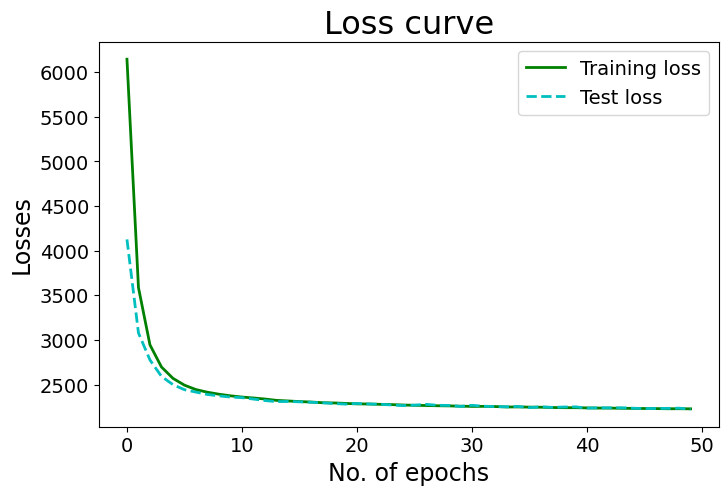

In [17]:
plt.figure(figsize=(8, 5))

plt.plot(training_loss, 'g-', linewidth=2, label='Training loss')
plt.plot(test_loss, 'c--', linewidth=2, label='Test loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=17)
plt.ylabel('Losses', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14);

## 12. Model prediction

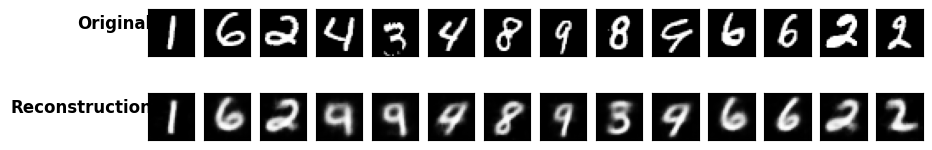

In [18]:
ORG, REC = [], []

for a in range(14):
    idx = np.random.randint(len(test_dataset))
    ORG.append(test_dataset[idx][0])
    REC.append(conv_vae.cpu()(ORG[a].unsqueeze(0))[0])
    
fig, ax = plt.subplots(nrows=2, ncols=14, figsize=(10, 2))

for i in range(14):
    ax[0, i].imshow(ORG[i].squeeze(), cmap='Greys_r')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].imshow(REC[i].squeeze().cpu().detach().numpy(), cmap='Greys_r')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

ax[0, 0].set_ylabel('Original', fontsize=12, rotation=0, labelpad=24, fontweight='bold')
ax[1, 0].set_ylabel('Reconstruction', fontsize=12, rotation=0, labelpad=48, fontweight='bold');

We randomly selected 14 images from the test set and checked the corresponding `reconstruction` provided by the `Conv_VAE` model.

It's very difficult to understand but if you closely look, you can notice that the reconstructed images are much better in this case compared to what we got using `VAE` model in the previous video. Nevertheless, there are fine differences between the original and reconstructed images. Moreover, The sixth and seventh reconstructed images in the above picture don't look very similar to their original equivalents.

## 13. Create samples from noise vectors

In [19]:
conv_vae.decoder

Sequential(
  (lat2hid): Linear(in_features=2, out_features=128, bias=True)
  (relu4): ReLU(inplace=True)
  (reshape): Reshape()
  (tconv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bnorm4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu5): ReLU(inplace=True)
  (tconv2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bnorm5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu6): ReLU(inplace=True)
  (tconv1): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bnorm6): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid1): Sigmoid()
)

The size of the `input_vector` to the decoder will have to be: `(16, 1, 1)` ===> `(C, H, W)`.

In [20]:
conv_vae.decoder

Sequential(
  (lat2hid): Linear(in_features=2, out_features=128, bias=True)
  (relu4): ReLU(inplace=True)
  (reshape): Reshape()
  (tconv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bnorm4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu5): ReLU(inplace=True)
  (tconv2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bnorm5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu6): ReLU(inplace=True)
  (tconv1): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bnorm6): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid1): Sigmoid()
)

In [21]:
with torch.inference_mode():
    noise_vecs = torch.randn(180, 2)
    print(noise_vecs.shape)
    sampled = conv_vae.decoder(noise_vecs)
    print(sampled.shape)
    gen_imgs = make_grid(sampled, nrow=18).permute(1, 2, 0)

torch.Size([180, 2])
torch.Size([180, 1, 28, 28])


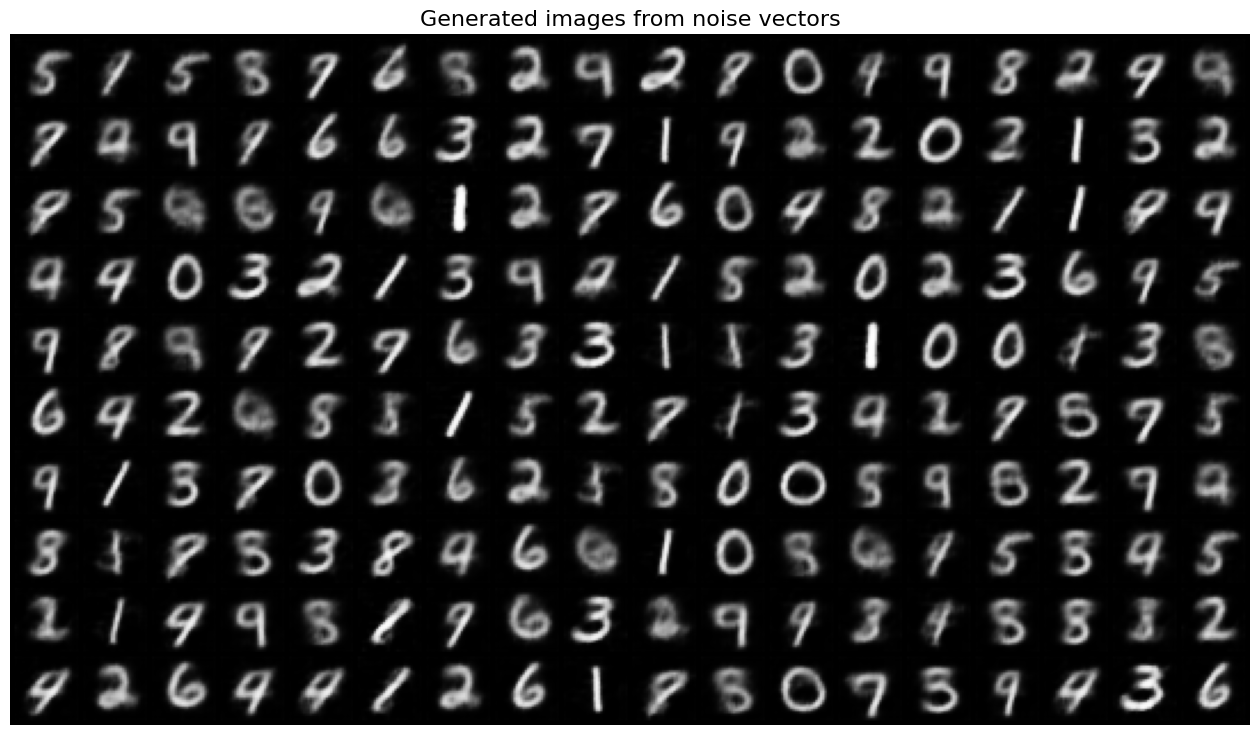

In [22]:
plt.figure(figsize=(16, 10))
plt.imshow(gen_imgs, cmap='Greys_r')
plt.title('Generated images from noise vectors', fontsize=16)
plt.axis(False);

In [ ]:
# show 18 randomly selected samples from the training dataset
fig, axis = plt.subplots(nrows=2, ncols=9, figsize=(10, 3))

for ax, _ in zip(axis.ravel(), range(18)):
    inx = np.random.randint(len(train_dataset))
    ax.imshow(train_dataset.data[inx], cmap='Greys_r')
    ax.set_title(train_dataset.targets[inx].item(), fontsize=12)
    ax.axis(False);
plt.suptitle("Train dataset sample", y=1.05, fontsize=14)
plt.show()

In [32]:
all_z = []
for batch in training_dataloader:
    x, y = batch
    print(x.shape)
    encoded = conv_vae.encoder(x)
    print(encoded.shape)
    encoded = encoded.view(encoded.shape[0], -1)
    print(encoded.shape)
    mu, logvar = conv_vae._mu(encoded), conv_vae._logvar(encoded)
    print(mu.shape, logvar.shape)

    z = conv_vae.reparameterization(mu, logvar)
    print(z.shape)

    break

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 2, 2])
torch.Size([64, 128])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2])


In [33]:
torch.save(conv_vae.state_dict(), "conv_vae_mnist.pt")

In [ ]:
z1, z2 = 

We generated 180 images from noise vectors. They simply don't look good after 100 epochs. So, the model needs to be trained for higher number of epochs.